In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import regularizers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from keras.models import load_model
from PyFunctions import Viz
from keras.preprocessing.image import ImageDataGenerator
from PyFunctions import Functions as func

Using plaidml.keras.backend backend.


In [2]:
model_name = 'normal'


x_train, x_test, y_train, y_test = func.get_emotion_splits(dim = (48,48), model_type = model_name, max_values = 4000, bw = True) 
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

TRAIN Value Count
2    4000
1    4000
0    3995
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TEST Value Count
1    1774
2    1233
0     958
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(11995, 48, 48, 3) (3965, 48, 48, 3)
(11995, 3) (3965, 3)


In [12]:
def get_conv_model(dim): 
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = dim))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.25))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax', name = 'Output'))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model



In [14]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=5, min_delta = .00075)
model_checkpoint = ModelCheckpoint(f'ModelWeights/Normal_Emotions.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 32
augment = False  

dim = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
cnn = get_conv_model(dim =dim)

if augment == True:   
    train_aug =ImageDataGenerator(rotation_range = 40, width_shift_range = .2, height_shift_range = .2, 
                                                           horizontal_flip = True, shear_range = .15, 
                                     fill_mode = 'nearest', zoom_range = .15)
    # augmentation.fit(x_train)
    cnn_history = cnn.fit_generator(train_aug.flow(x_train, y_train, batch_size = batch_size),
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

else: 
    cnn_history = cnn.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

Train on 11995 samples, validate on 3965 samples
Epoch 1/2000
11995/11995 [==============================] - 31s 3ms/step - loss: 1.0477 - acc: 0.4345 - val_loss: 0.9020 - val_acc: 0.5786

Epoch 00001: val_loss improved from inf to 0.90200, saving model to ModelWeights/Normal_Masks.h5
Epoch 2/2000
11995/11995 [==============================] - 13s 1ms/step - loss: 0.8822 - acc: 0.5857 - val_loss: 0.7447 - val_acc: 0.6772

Epoch 00002: val_loss improved from 0.90200 to 0.74473, saving model to ModelWeights/Normal_Masks.h5
Epoch 3/2000
11995/11995 [==============================] - 13s 1ms/step - loss: 0.7647 - acc: 0.6596 - val_loss: 0.6819 - val_acc: 0.7004

Epoch 00003: val_loss improved from 0.74473 to 0.68187, saving model to ModelWeights/Normal_Masks.h5
Epoch 4/2000
11995/11995 [==============================] - 13s 1ms/step - loss: 0.6951 - acc: 0.6904 - val_loss: 0.6079 - val_acc: 0.7395

Epoch 00004: val_loss improved from 0.68187 to 0.60792, saving model to ModelWeights/Normal_

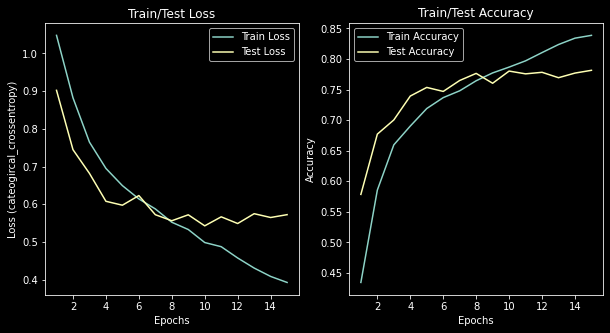

In [15]:
Viz.plot_loss_accuracy(cnn_history, 'dark_background', path = 'Images/Normal_Loss_Acc.png')

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
Angry(0): 0.6973140495867769
Happy(1): 0.8615123194562448
Neutral(2): 0.729192042224929


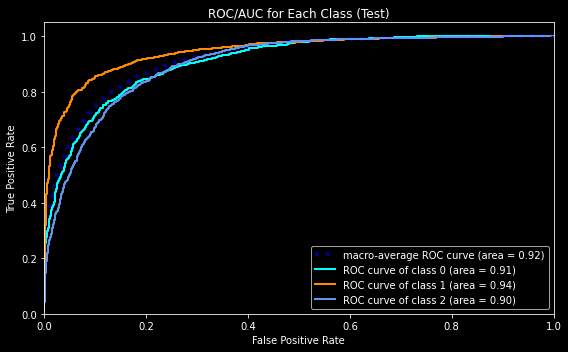

In [4]:
cnn = load_model('ModelWeights/Normal_Emotions.h5')
Viz.plot_roc_auc(cnn, x_test, y_test, 'dark_background', 'emotion', path = 'Images/Normal_ROC.png')

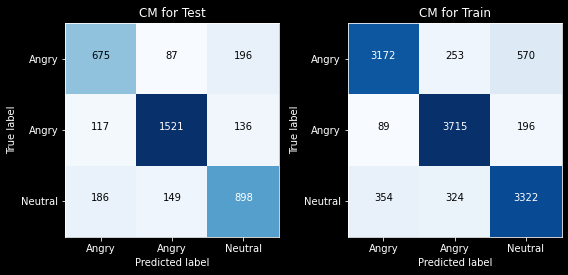

In [6]:
cnn = load_model('ModelWeights/Normal_Emotions.h5')
y_test_prob = [np.argmax(i) for i in cnn.predict(x_test)]
y_test_labels = [np.argmax(i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

train_prob = [np.argmax(i) for i in cnn.predict(x_train)]
train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(train_labels, train_prob)

#this function creates a confusion matrix given the confusion matrixes of test and train
Viz.plot_model_cm(test_cnf, train_cnf, classes = ['Angry', 'Angry', 'Neutral'], theme = 'dark_background', 
                  model_type = 'emotion', path = 'Images/Normal_CM.png')